## A/B testing analysis

By default $\alpha$ = 0.05

Info about data:

    There're users which were conducted a/b test on, they were divided on 2 groups (slots): control and experimental (exp)

In [56]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [46]:
ALPHA = 0.05
SEED = 0

In [2]:
df = pd.read_csv('ab_browser_test.csv')
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
df_exp = df.loc[df['slot']=='exp']
df_control = df.loc[df['slot']=='control']

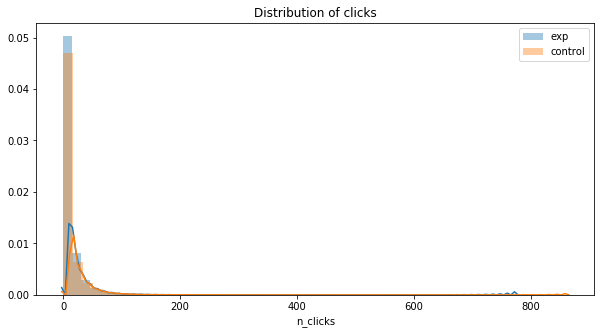

In [24]:
plt.figure(figsize=(10,5))
plt.title('Distribution of clicks')
sns.distplot(df_exp['n_clicks'], label='exp')
sns.distplot(df_control['n_clicks'], label='control')
plt.legend(loc='best')
plt.show()

### 1

In [19]:
print((sum(df_exp['n_clicks']) - sum(df_control['n_clicks'])) / sum(df_control['n_clicks']) * 100, '%')

1.6135689824415809 %


### 2

In [25]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [27]:
np.random.seed(SEED)

medians_exp = list(map(np.median, get_bootstrap_samples(df_exp['n_clicks'].values, 1000)))
medians_control = list(map(np.median, get_bootstrap_samples(df_control['n_clicks'].values, 1000)))


means_exp = list(map(np.mean, get_bootstrap_samples(df_exp['n_clicks'].values, 1000)))
means_control = list(map(np.mean, get_bootstrap_samples(df_control['n_clicks'].values, 1000)))

In [41]:
print("95% confidence interval for the exp slot median :",  stat_intervals(medians_exp, ALPHA))
print("95% confidence interval for the control slot median :",  stat_intervals(medians_control, ALPHA))

print("95% confidence interval for the exp slot mean :",  stat_intervals(means_exp, ALPHA))
print("95% confidence interval for the control slot mean :",  stat_intervals(means_control, ALPHA))

95% confidence interval for the exp slot median : [5. 5.]
95% confidence interval for the control slot median : [4. 4.]
95% confidence interval for the exp slot mean : [11.50674915 11.65758017]
95% confidence interval for the control slot mean : [11.21242374 11.35449133]


In [42]:
delta_medians = list(map(lambda x: x[1] - x[0], zip(medians_control, medians_exp)))
delta_means = list(map(lambda x: x[1] - x[0], zip(means_control, means_exp)))

In [44]:
print(f"95% confidence interval for the difference between medians: {stat_intervals(delta_medians, ALPHA)}")
print(f"95% confidence interval for the difference between means: {stat_intervals(delta_means, ALPHA)}")

95% confidence interval for the difference between medians: [1. 1.]
95% confidence interval for the difference between means: [0.19866114 0.40975645]


### 3
question without computations

### 4

In [47]:
np.random.seed(SEED)
boost_samples = get_bootstrap_samples(df_control['n_clicks'].values, 500)

In [49]:
means_boost = list(map(np.mean, boost_samples))

In [52]:
emp_mean = df_control['n_clicks'].mean()
def tss(sample):
    return sum((sample - emp_mean)**2)

tss_boost = list(map(tss, boost_samples))

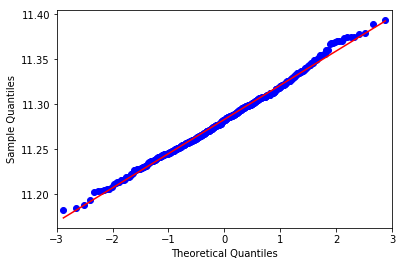

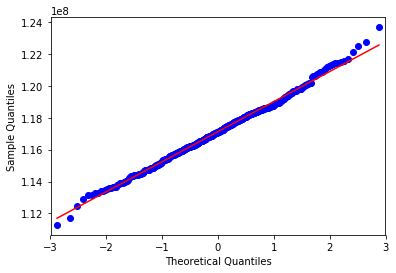

In [79]:
sm.qqplot(np.array(means_boost), line='r')
sm.qqplot(np.array(tss_boost), line='r')
plt.show()

0.998889957441537 0.9977811470775555


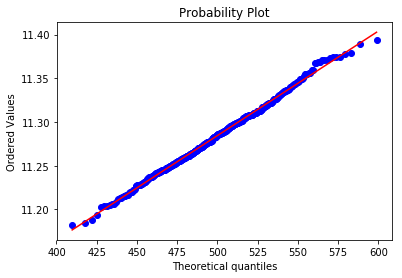

In [84]:
r_mean = stats.probplot(means_boost, dist="chi2", sparams=(len(means_boost)-1), plot=plt)[1][2]
print(r_mean, r_mean**2)

0.9986410687320381 0.9972839841582671


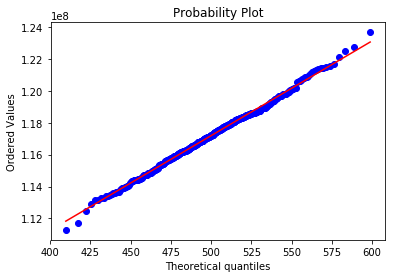

In [85]:
r_tss = stats.probplot(tss_boost, dist="chi2", sparams=(len(tss_boost)-1), plot=plt)[1][2]
print(r_tss, r_tss**2)

### 5 

In [93]:
sum_clicks_control = df_control.groupby(by=['userID'])['n_clicks'].sum()
sum_clicks_exp = df_exp.groupby(by=['userID'])['n_clicks'].sum()

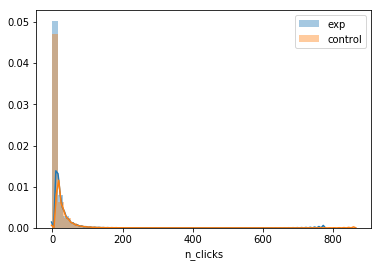

In [98]:
sns.distplot(sum_clicks_exp, label='exp')
sns.distplot(sum_clicks_control, label='control')
plt.legend(loc='best')
plt.show()

In [101]:
print(stats.mannwhitneyu(sum_clicks_control.values, sum_clicks_exp.values))

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)


### 6

In [131]:
import statsmodels.stats.multitest as smm

In [107]:
uniq_browsers = df['browser'].unique()

In [117]:
d1, d2 = {}, {}
for browser in uniq_browsers:
    d1[browser] = df_control[df_control['browser']==browser].groupby(by=['userID'])['n_clicks'].sum()
    d2[browser] = df_exp[df_exp['browser']==browser].groupby(by=['userID'])['n_clicks'].sum()

In [129]:
p_vals = {}
for browser in uniq_browsers:
    p_vals[browser] = stats.mannwhitneyu(d1[browser], d2[browser])[1]
print(p_vals)

{'Browser #2': 0.0272438604197241, 'Browser #4': 0.40760617658454984, 'Browser #14': 0.0, 'Browser #17': 0.03740060143010802, 'Browser #20': 0.45366656388735377, 'Browser #22': 0.2574055152210032}


In [130]:
for k, p in p_vals.items():
    if p < ALPHA:
        print(k)

Browser #2
Browser #14
Browser #17


In [136]:
#Holm-Bonferroni correction since we'd like to test several hypotheses
reject, p_corrected, a1, a2 = smm.multipletests(list(p_vals.values()), alpha=ALPHA, method='holm')
#number of statistically nonsignificant differences
print(len(np.where(p_corrected > ALPHA)[0]))

5


### 7

In [162]:
uniq_browsers = df['browser'].unique()
d1, d2 = {}, {}
for browser in uniq_browsers:
    cont_br = df_control.loc[df_control['browser']==browser, ['n_nonclk_queries', 'n_queries']].sum()
    exp_br = df_exp.loc[df_exp['browser']==browser, ['n_nonclk_queries', 'n_queries']].sum()
    
    d1[browser] = (cont_br['n_nonclk_queries'] / cont_br['n_queries'] * 100)
    d2[browser] = (exp_br['n_nonclk_queries'] / exp_br['n_queries'] * 100)
    

In [166]:
for br in uniq_browsers:
    print(f"{br} control: {d1[br]}, exp: {d2[br]}, diff: {d1[br]-d2[br]}")

Browser #2 control: 45.96274717919465, exp: 44.982746948554706, diff: 0.9800002306399449
Browser #4 control: 46.97092963514274, exp: 45.14294190358467, diff: 1.8279877315580677
Browser #14 control: 57.59041136008114, exp: 43.755617361273295, diff: 13.834793998807847
Browser #17 control: 36.29936674628208, exp: 36.93741284866483, diff: -0.6380461023827451
Browser #20 control: 40.540484743383296, exp: 38.97737648371716, diff: 1.5631082596661372
Browser #22 control: 40.593976593513354, exp: 39.85394721969546, diff: 0.7400293738178902
